## Loyalty Program Analysis
Dataset contains data on purchases made at the building-material retailer Home World. Analyze the store's loyalty program and do the following tasks:
- Carry out exploratory data analysis
- Analyze the loyalty program
- Formulate and test statsistical hypotheses

## Dashboard
https://public.tableau.com/views/RetailPurchasesDashboard/FinalDashboard?:language=en-US&:display_count=n&:origin=viz_share_link

## Presentation
https://drive.google.com/file/d/11OcK1N_drTXHJRLHhd3fN0kY8py7OmEP/view?usp=sharing

### Data Preprocessing
- Importing the data
- Changing datatypes on dates
- Changing datatypes in general (float to int)
- Checking for duplicates and missing values and taking action if necessary

In [53]:
#import pandas and other important libraries
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from plotly import graph_objects as go
import re
import math as mth
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime
from datetime import timedelta
from scipy.stats import levene

warnings.filterwarnings('ignore')

In [54]:
#read all input data and assign each dataset to a variable
try:
    retail = pd.read_csv('retail_dataset_us.csv', parse_dates=['purchasedate'])
except:
    retail = pd.read_csv('/datasets/retail_dataset_us.csv', parse_dates=['purchasedate'])
    
try:
    products = pd.read_csv('product_codes_us.csv', sep=';')
except:
    products = pd.read_csv('/datasets/product_codes_us.csv', sep=';')

In [55]:
#checking info and looking for duplicates and missing values
retail.info()
print('\nNumber of duplicates found: ', retail.duplicated().sum())
retail.drop_duplicates(inplace=True)
print('\nNumber of duplicates found: ', retail.duplicated().sum())
print('\nNumber of missing values found: ')
print(retail.isna().sum())

#creating new columns for date and time
retail['Date'] = pd.DatetimeIndex(retail['purchasedate']).date.astype('datetime64[ns]')
retail['Time'] = pd.DatetimeIndex(retail['purchasedate']).time

retail.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchaseid       105335 non-null  object        
 1   item_ID          105335 non-null  object        
 2   Quantity         105335 non-null  int64         
 3   purchasedate     105335 non-null  datetime64[ns]
 4   CustomerID       69125 non-null   float64       
 5   loyalty_program  105335 non-null  int64         
 6   ShopID           105335 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.6+ MB

Number of duplicates found:  1033

Number of duplicates found:  0

Number of missing values found: 
purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36148
loyalty_program        0
ShopID                 0
dtype: int64


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,Date,Time
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3,2016-12-10,12:50:00
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2,2016-12-14,14:11:00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3,2016-12-14,13:50:00
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28,2017-02-09,15:33:00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28,2017-02-13,14:40:00


In [56]:
#checking info and looking for duplicates and missing values
products.info()
print('\nNumber of duplicates found: ', products.duplicated().sum())
print('\nNumber of missing values found: ')
print(products.isna().sum())
products.columns = ['item_ID', 'price_per_one']
products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      3159 non-null   object 
 1   price_per_one  3159 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.5+ KB

Number of duplicates found:  0

Number of missing values found: 
productID        0
price_per_one    0
dtype: int64


,item_ID,price_per_one
0,10002,0.85
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


In [57]:
#merging products to retail_full
retail_full = retail.merge(products, on='item_ID', how='left')
retail_full

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,Date,Time,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3,2016-12-10,12:50:00,0.42
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2,2016-12-14,14:11:00,1.65
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3,2016-12-14,13:50:00,0.72
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28,2017-02-09,15:33:00,2.55
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28,2017-02-13,14:40:00,0.00
...,...,...,...,...,...,...,...,...,...,...
104297,538566,21826,1,2016-12-13 11:21:00,NaN,0,Shop 0,2016-12-13,11:21:00,1.25
104298,540247,21742,0,2017-01-05 15:56:00,21143.0,0,Shop 24,2017-01-05,15:56:00,5.95
104299,538068,85048,1,2016-12-09 14:05:00,23657.0,1,Shop 16,2016-12-09,14:05:00,6.95
104300,538207,22818,11,2016-12-10 11:33:00,18427.0,0,Shop 29,2016-12-10,11:33:00,0.42


##### Conclusion

All the necessary data has been converted. There were some duplicated rows, but it was solved with no issue. There are missing values under CustomerID, but I decided to keep it that way. Missing CustomerID most likely just means that the customer didn't sign up, and just purchased directly. 

I then merged everything together, and now the dataset is ready.

### EDA
- Find the first date and end date
- Find how many people are in the loyalty program
- Find total amount per purchase
- Find the average total by loyalty program
- Find the average quantity by loyalty program
- Find the average purchase frequency by loyalty program
- Plot the distribution of purchases by day
- Plot out the different stores, see if there is a difference in popularity
- Checking which items are bought the most and which are not bought at all



#### Finding first date and end date

In [58]:
#finding first and end date by doing min and max
print(retail_full['Date'].min())
print(retail_full['Date'].max())

2016-12-01 00:00:00
2017-02-28 00:00:00


##### Conclusion

The first date found in the dataset is 2016 December 1st while the last most recent date is 2017 February 28th

#### How many people are in the loyalty program?

In [59]:
#finding how many people are under the loyalty program
retail_full['loyalty_program'].value_counts()

0    80890
1    23412
Name: loyalty_program, dtype: int64

##### Conclusion

23412 users are under the loyalty program, which means that 22% of the total users are under the loyalty program

#### Add a new column to the dataset and find total amount per purchase

In [60]:
#checking to see what values I'm dealing with, and if I have negative values
#retail_full['Quantity'].value_counts()

#changing negative values to positive
retail_full['Quantity'] = retail_full['Quantity'].abs()

#checking if there is a difference
retail_full['Quantity'].value_counts()

0       32362
1       16137
11      10302
2        8281
5        8059
        ...  
899         1
178         1
201         1
1299        1
2601        1
Name: Quantity, Length: 235, dtype: int64

In [61]:
#adding 1 to each quantity so I can calculate total in the next block.
retail_full['Quantity'] += 1

In [62]:
#calculating total for each purchase row
retail_full['Total'] = retail_full['price_per_one'] * retail_full['Quantity']
retail_full

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,Date,Time,price_per_one,Total
0,538280,21873,12,2016-12-10 12:50:00,18427.0,0,Shop 3,2016-12-10,12:50:00,0.42,5.04
1,538862,22195,1,2016-12-14 14:11:00,22389.0,1,Shop 2,2016-12-14,14:11:00,1.65,1.65
2,538855,21239,8,2016-12-14 13:50:00,22182.0,1,Shop 3,2016-12-14,13:50:00,0.72,5.76
3,543543,22271,1,2017-02-09 15:33:00,23522.0,1,Shop 28,2017-02-09,15:33:00,2.55,2.55
4,543812,79321,1,2017-02-13 14:40:00,23151.0,1,Shop 28,2017-02-13,14:40:00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
104297,538566,21826,2,2016-12-13 11:21:00,NaN,0,Shop 0,2016-12-13,11:21:00,1.25,2.50
104298,540247,21742,1,2017-01-05 15:56:00,21143.0,0,Shop 24,2017-01-05,15:56:00,5.95,5.95
104299,538068,85048,2,2016-12-09 14:05:00,23657.0,1,Shop 16,2016-12-09,14:05:00,6.95,13.90
104300,538207,22818,12,2016-12-10 11:33:00,18427.0,0,Shop 29,2016-12-10,11:33:00,0.42,5.04


The reason why I added 1 to quantity is because some quantities are listed as 0. Seeing this, it would make sense that the customer actually did purchase 1 instead of 0. This also means that if a person had their Quantity listed as 11, it means that they actually purchased 12.

#### Average purchase total between loyalty groups

In [63]:
#separating retail_full by those who are under the loyalty program for future tasks
loyalty1 = retail_full.query('loyalty_program == 1')
loyalty0 = retail_full.query('loyalty_program == 0')

In [64]:
print('Customers NOT under loyalty program average purchase total:',round(loyalty0['Total'].mean()))
print('Customers under loyalty program average purchase total:',round(loyalty1['Total'].mean()))

Customers NOT under loyalty program average purchase total: 13
Customers under loyalty program average purchase total: 14


##### Conclusion

From looking at the average total from each customers by loyalty program, we can see that the difference isn't much. If anything there IS a slight increase by 1 dollar from customers that are under the loyalty program.

#### Average purchase quantity between loyalty groups

In [65]:
print('Customers NOT under loyalty program average quantity:',round(loyalty0['Quantity'].mean()))
print('Customers under loyalty program average quantity:',round(loyalty1['Quantity'].mean()))

Customers NOT under loyalty program average quantity: 11
Customers under loyalty program average quantity: 11


##### Conclusion

Looking at the average quantity purchased from each customer by loyalty program, we can see that there is no visible difference. 

#### Average purchase frequency for loyal/non-loyal customers

In [66]:
print('Customers NOT under loyalty program average purchase frequency:',round(loyalty0['purchaseid'].value_counts().mean()))
print('Customers under loyalty program average purchase frequency:',round(loyalty1['purchaseid'].value_counts().mean()))

Customers NOT under loyalty program average purchase frequency: 23
Customers under loyalty program average purchase frequency: 17


##### Conclusion

From the average purchase frequency for loyal/non-loyal customers, we can see that customers NOT under the program have an average frequency of 23 purchases. Interestingly enough, customers under the loyalty program have the average frequency of 17, which is surprisingly lower considering the fact that loyalty customers get special offers, discounts, and more incentive to come back to the store.

#### What are the purchases distributed by day?

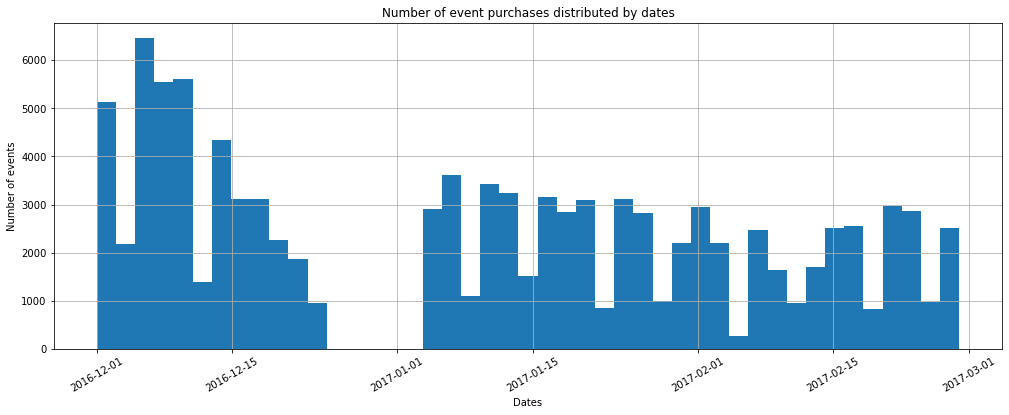

In [67]:
#plotting the graph
plt.figure(figsize= (17, 6))
retail_full['Date'].hist(bins=45)
plt.xticks(rotation=30)
plt.title('Number of event purchases distributed by dates')
plt.xlabel('Dates')
plt.ylabel('Number of events')
plt.show()

##### Conclusion

From this graph, we learn learn the purchases from each customer distributed by day. The day with the most number of purchases (peaking near 5k) is around the 6th of December 2016.

#### Plot out the different stores, see if there is a difference in popularity

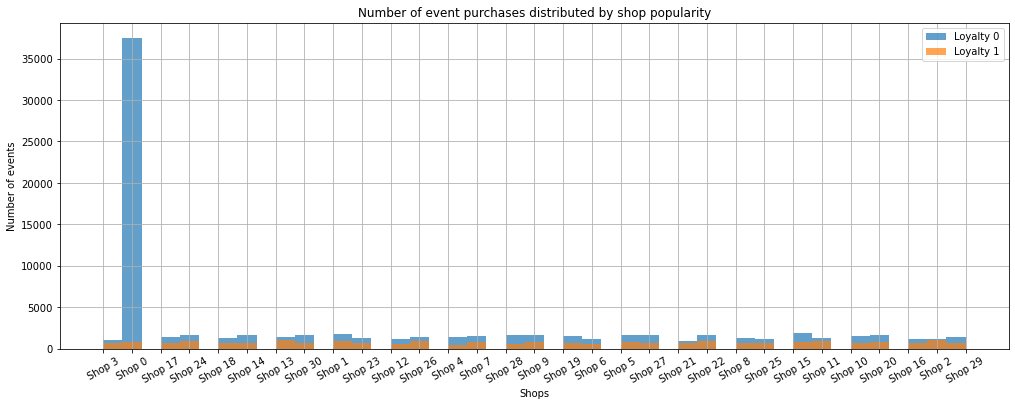

In [68]:
#plotting the graph
plt.figure(figsize= (17, 6))
loyalty0['ShopID'].hist(bins=45, label='Loyalty 0', alpha = 0.7)
loyalty1['ShopID'].hist(bins=45, label='Loyalty 1', alpha = 0.7)
plt.xticks(rotation=30)
plt.title('Number of event purchases distributed by shop popularity')
plt.xlabel('Shops')
plt.ylabel('Number of events')
plt.legend()
plt.show()

In [69]:
#outputting a simple table of how many purchases are made in each shop
retail_full['ShopID'].value_counts()

Shop 0     38303
Shop 1      2689
Shop 15     2679
Shop 24     2624
Shop 22     2538
Shop 5      2469
Shop 9      2447
Shop 13     2411
Shop 20     2402
Shop 14     2366
Shop 30     2359
Shop 7      2311
Shop 28     2306
Shop 26     2299
Shop 27     2296
Shop 11     2274
Shop 2      2224
Shop 19     2209
Shop 29     2181
Shop 10     2181
Shop 17     2164
Shop 23     2041
Shop 18     1995
Shop 4      1964
Shop 8      1963
Shop 16     1920
Shop 25     1902
Shop 12     1758
Shop 3      1703
Shop 6      1673
Shop 21     1651
Name: ShopID, dtype: int64

##### Conclusion

As we can see with this graph and table, Shop 0 is clearly the winner here having an astounding difference compared to every other store.

#### Checking which items are bought the most and which are not bought at all

In [70]:
print('These are the items that are the most bought')
print(retail_full['item_ID'].value_counts().head())
print('\nThese are the items that are the least bought')
print(retail_full['item_ID'].value_counts().tail())

These are the items that are the most bought
85123A    561
22423     497
22469     412
22720     375
85099B    372
Name: item_ID, dtype: int64

These are the items that are the least bought
DCGS0072    1
22125       1
21226       1
84977       1
79320       1
Name: item_ID, dtype: int64


In [71]:
print(products.query('item_ID == "85123A"'))
print(products.query('item_ID == "22423"'))
print(products.query('item_ID == "22469"'))

     item_ID  price_per_one
2700  85123A            0.0
     item_ID  price_per_one
1287   22423            0.0
     item_ID  price_per_one
1330   22469           1.45


In [72]:
print(products.query('item_ID == "21226"'))
print(products.query('item_ID == "84977"'))
print(products.query('item_ID == "79320"'))

    item_ID  price_per_one
428   21226           1.25
     item_ID  price_per_one
2562   84977            0.0
     item_ID  price_per_one
2184   79320           4.95


##### Conclusion
Items that are the most bought, and the least bought are listed above. Most popular being 85123A with 561 purchases, and least bought seemingly a lot.

However, when looking into pricing of these most popular and least popular items, we can see that some of these items actually cost 0 per item.

### Testing null hypotheses regarding if having a loyalty program would get the customers to spend/buy more than those customers that aren't under the program

#### The null hypotheses used
- H0 is to see if customers under the loyalty program DON'T spend more then those regular customers without the program.
- H1 is to see if customers under the loyalty program DO spend more than those regular customers without the program.

In [73]:
stat, p = levene(loyalty0['Total'], loyalty1['Total'])
p

0.978447836307335

Because the p value is close to 1, this suggests that Total has equal variances. Because of this, I will set equal_var on the t-test as True.

In [74]:
#separating retail_full by those who are under the loyalty program for the t-test
loyalty1 = retail_full.query('loyalty_program == 1')
loyalty0 = retail_full.query('loyalty_program == 0')

alpha = 0.05

results = st.ttest_ind(loyalty1['Total'], loyalty0['Total'], equal_var = True)

print('p-value:', results.pvalue)

if(results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value: 0.8174724003340338
We can't reject the null hypothesis


##### Conclusion

From the t-test i've conducted, we can't reject the null hypothesis, and that customers under the loyalty program DON'T spend more then those regular customers without the program.

#### The null hypotheses used
- H0 is to see if customers under the loyalty program DON'T buy more then those regular customers without the program.
- H1 is to see if customers under the loyalty program DO buy more than those regular customers without the program.

In [75]:
#checking if quantity has equal variances
stat, p = levene(loyalty0['Quantity'], loyalty1['Quantity'])
p

0.8783813731356556

Because the p value is close to 1, this suggests that Total has equal variances. Because of this, I will set equal_var on the t-test as True.

In [76]:
#separating retail_full by those who are under the loyalty program for the t-test
loyalty1 = retail_full.query('loyalty_program == 1')
loyalty0 = retail_full.query('loyalty_program == 0')

alpha = 0.05

results = st.ttest_ind(loyalty1['Quantity'], loyalty0['Quantity'], equal_var = True)

print('p-value:', results.pvalue)

if(results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value: 0.9958864529714223
We can't reject the null hypothesis


##### Conclusion

From the t-test i've conducted, we can't reject the null hypothesis, and that customers under the loyalty program DON'T buy more then those regular customers without the program.

## Conclusion

From what I can conclude from the t-tests is that there is NO statstical difference between customers that are under the loyalty program and those customers who aren't. Between quantity and final buy total, there is NO statstical difference.

### Sources

https://stackoverflow.com/questions/29077188/absolute-value-for-column-in-python

This article helped me with changing negative values to positive.

https://plotly.com/python/bar-charts/

This article helped me with the making of bar charts for EDA. With this, I was able to output both loyalty groups for shop purchases, and date purchases.

https://www.bristol.ac.uk/medical-school/media/rms/red/which_test.html

This source helped me determine which type of test to conduct for my null hypotheses. With this, I was able to conclude that I should use t-test for this type of data.

https://scipy.github.io/devdocs/reference/generated/scipy.stats.levene.html?highlight=levene#scipy.stats.levene

This doc helped with testing variance, and determining whether or not the variances were equal

https://docs.scipy.org/doc/scipy/reference/stats.html

This documentation helped me with conducting the actual t-test. I was able to get correct syntex and usage from this page, and it helped with testing my null hypotheses.

https://help.tableau.com/current/pro/desktop/en-us/calculations_calculatedfields_formulas.htm

This article helped with creating calculated fields for my dashboard, which I then used to calculate % of total.

https://community.tableau.com/s/question/0D54T00000C6BQCSA3/size-of-pie-charts

This article helped with increasing the size of the pie chart for my dashboard. This helped with making the visual look bigger and nicer 